In [1]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import re
import torch

from src.dataset import extract_array_as_HU, apply_ct_abdomen_filter
from src.config import directories
from src.models import UNet

In [2]:
patient_ids = sorted([int(f) for f in os.listdir(os.path.join(directories['chaos'], f'Train_Sets/CT/'))])
encoding = {p:idx for idx, p in enumerate(patient_ids)}

# Find Nearest Neighbor
Compute affine transform matrix determinant for each registration pair

In [3]:
matrix_dir = os.path.join(directories['chaos_registrations'], 'affine')
mat_regex = re.compile('volume-(\d+).*volume-(\d+).*\.mat$')
patient_regex = re.compile('volume-(\d+)\.nii$')

patient_matches = [patient_regex.search(fp) for fp in sorted(os.listdir(matrix_dir)) if patient_regex.search(fp)]
matches = [mat_regex.search(fp) for fp in sorted(os.listdir(matrix_dir)) if mat_regex.search(fp)]
patient_ids = sorted([int(m.group(1)) for m in patient_matches])
encoding = {f'{p}':idx for idx, p in enumerate(patient_ids)}
decoding = {idx:p for idx, p in enumerate(patient_ids)}

n = len(patient_matches)
distance_matrix = np.zeros((n, n))

for match in matches:
    
    mat_fp = os.path.join(matrix_dir, match.group(0))
    source_id, target_id = match.group(1), match.group(2)
    arr = np.fromfile(mat_fp, sep=" ", dtype=np.float64)
    
    # Need a matrix not a vector
    arr = arr.reshape((4,4))
    
    det = np.linalg.det(arr)
    row, col = encoding[source_id], encoding[target_id]
    distance_matrix[row, col] = det

Nearest Patient: 14. Column: 7


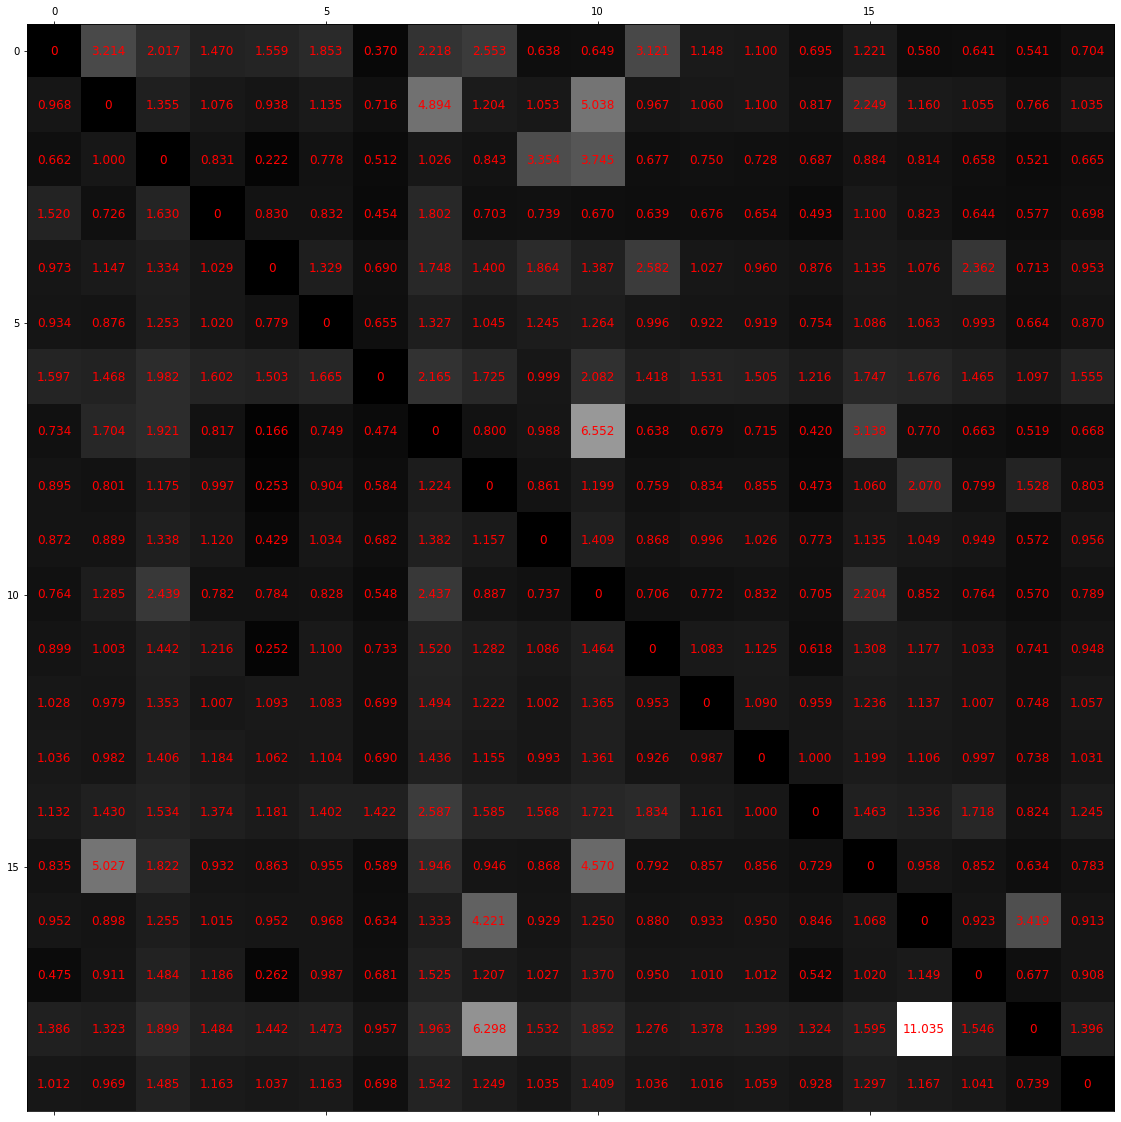

In [4]:
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(distance_matrix, cmap="gray")
for i in range(n):
    for j in range(n):
        norm = distance_matrix[i, j]
        text = f'{norm:.3f}' if norm != 0 else '0'
        ax.text(j, i, text,
                ha="center", va="center", color="r",
                size=12)
averages = distance_matrix.mean(axis=0)
nearest_neighbor = decoding[np.argmin(averages)]
print(f'Nearest Patient: {nearest_neighbor}. Column: {np.argmin(averages)+1}')

# Register Volumes to Nearest Neighbor

In [ ]:
# TODO 
# Run ./affine_reg.sh -t nearest_neighbor.nii